🆕 Erstelle neues Modell...
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11436/11436 ━━━━━━━━━━━━━━━━━━━━ 498s 43ms/step - loss: 4.4329e-04 - val_loss: 4.7843e-04
Epoch 2/10
11436/11436 ━━━━━━━━━━━━━━━━━━━━ 489s 43ms/step - loss: 7.2039e-05 - val_loss: 5.6697e-04
Epoch 3/10
11436/11436 ━━━━━━━━━━━━━━━━━━━━ 512s 45ms/step - loss: 6.6167e-05 - val_loss: 4.4506e-04
Epoch 4/10
11436/11436 ━━━━━━━━━━━━━━━━━━━━ 518s 45ms/step - loss: 6.4070e-05 - val_loss: 5.1728e-04
Epoch 5/10
11436/11436 ━━━━━━━━━━━━━━━━━━━━ 497s 44ms/step - loss: 5.9973e-05 - val_loss: 4.3197e-04
Epoch 6/10
11436/11436 ━━━━━━━━━━━━━━━━━━━━ 499s 44ms/step - loss: 5.8379e-05 - val_loss: 4.3041e-04
Epoch 7/10
11436/11436 ━━━━━━━━━━━━━━━━━━━━ 490s 43ms/step - loss: 5.6619e-05 - val_loss: 4.6926e-04
Epoch 8/10
11436/11436 ━━━━━━━━━━━━━━━━━━━━ 491s 43ms/step - loss: 5.5842e-05 - val_loss: 5.3017e-04
Epoch 9/10
11436/11436 ━━━━━━━━━━━━━━━━━━━━ 495s 43ms/step - loss: 5.5102e-05 - val_loss: 4.5290e-04
Epoch 10/10
11436/11436 ━━━━━━━━━━━━━━━━━━━━ 29619s 3s/step - loss: 5.3721e-05 - val_loss: 4.5610e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


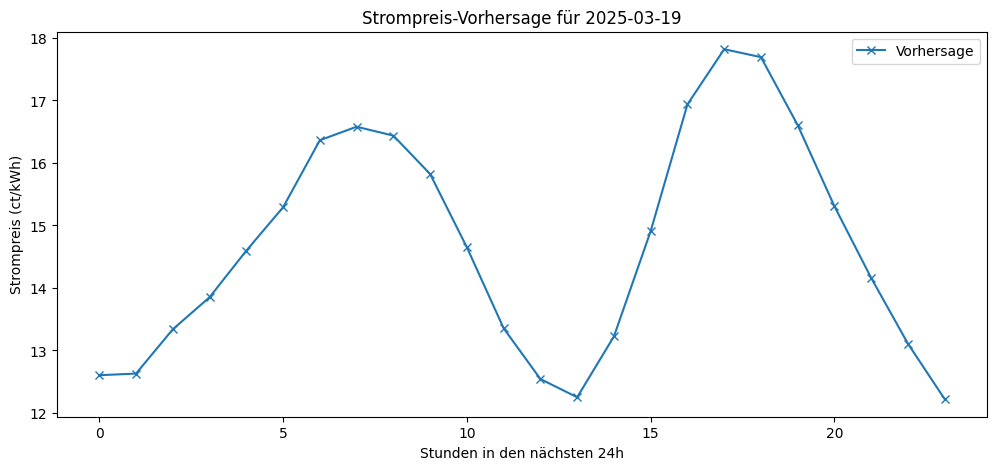

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime, timedelta


file_path = "/Users/Andre/vscode-projects/BI-Steel-Project/machine_learning/energy_prices_data.csv"
model_path = "energy_price_model.h5"  

# load data
df = pd.read_csv(file_path, sep=';', decimal=',')
df['Datetime'] = pd.to_datetime(df['Datum'] + ' ' + df['von'], format='%d.%m.%Y %H:%M')
df = df[['Datetime', 'Spotmarktpreis in ct/kWh']]
df.rename(columns={'Spotmarktpreis in ct/kWh': 'Spotpreis'}, inplace=True)
df.set_index('Datetime', inplace=True)

# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Spotpreis'] = scaler.fit_transform(df[['Spotpreis']])


def create_sequences(data, seq_length=336, output_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length - output_length):
        X.append(data[i:i + seq_length])  # 14 Tage Input
        y.append(data[i + seq_length:i + seq_length + output_length])  # 24 Stunden Output
    return np.array(X), np.array(y)


seq_length = 336  
output_length = 24  
data = df['Spotpreis'].values
X, y = create_sequences(data, seq_length, output_length)


X = X.reshape((X.shape[0], X.shape[1], 1))

# train test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


if os.path.exists(model_path):
    print("🔄 Lade vorhandenes Modell...")
    model = load_model(model_path)
else:
    print("🆕 Erstelle neues Modell...")
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
        LSTM(50),
        Dense(output_length) 
    ])
    model.compile(optimizer='adam', loss='mse')

if not os.path.exists(model_path):  
    model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))
    model.save(model_path)  


latest_data = np.array([data[-seq_length:]])
latest_data = latest_data.reshape((1, seq_length, 1))
predictions = model.predict(latest_data)  


predictions = scaler.inverse_transform(predictions)


plt.figure(figsize=(12, 5))
plt.plot(predictions[0], label="Vorhersage", marker='x')
plt.xlabel("Stunden in den nächsten 24h")
plt.ylabel("Strompreis (ct/kWh)")
plt.legend()
plt.title(f"Strompreis-Vorhersage für {datetime.now().strftime('%Y-%m-%d')}")
plt.show()


In [ ]:
if os.path.exists(model_path):
    print("🔄 Lade vorhandenes Modell...")
    model = load_model(model_path)
else:
    print("🆕 Erstelle neues Modell...")
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
        LSTM(50),
        Dense(output_length)  # 🔄 24 Werte als Output
    ])
    model.compile(optimizer='adam', loss='mse')

if not os.path.exists(model_path):  
    model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))
    model.save(model_path)  


latest_data = np.array([data[-seq_length:]])
latest_data = latest_data.reshape((1, seq_length, 1))
predictions = model.predict(latest_data)  


predictions = scaler.inverse_transform(predictions)

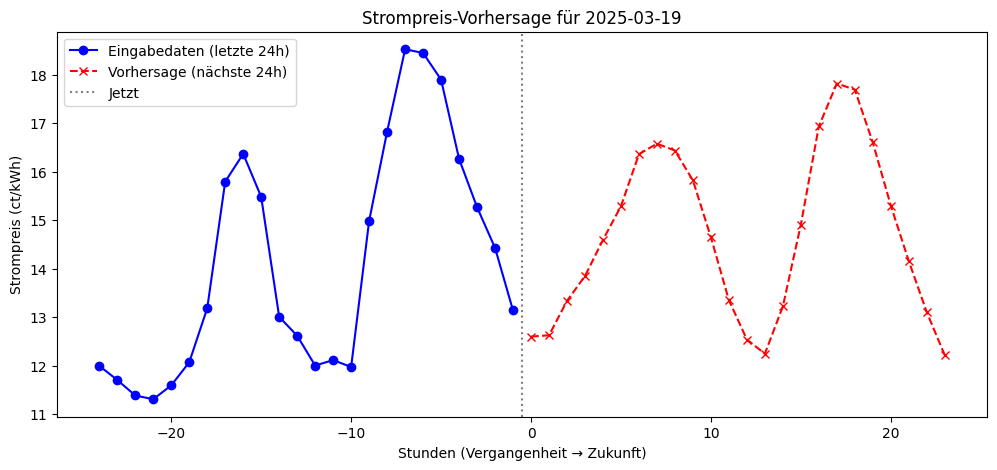

In [11]:
plt.figure(figsize=(12, 5))

# Letzte 24 Stunden aus den Input-Daten holen (zur Visualisierung)
input_last_24h = scaler.inverse_transform(data[-24:].reshape(-1, 1)).flatten()

# Plot für die echten Daten der letzten 24h
plt.plot(range(-24, 0), input_last_24h, label="Eingabedaten (letzte 24h)", marker='o', linestyle='-', color='blue')

# Plot für die Vorhersagen der nächsten 24h
plt.plot(range(0, 24), predictions[0], label="Vorhersage (nächste 24h)", marker='x', linestyle='--', color='red')

# Achsenbeschriftungen und Titel
plt.xlabel("Stunden (Vergangenheit → Zukunft)")
plt.ylabel("Strompreis (ct/kWh)")
plt.axvline(x=-0.5, color='gray', linestyle='dotted', label="Jetzt")  # Trennlinie zwischen Vergangenheit/Zukunft
plt.legend()
plt.title(f"Strompreis-Vorhersage für {datetime.now().strftime('%Y-%m-%d')}")

plt.show()
